In [1]:
import numpy as np
import tensorflow as tf
import uproot
import awkward as ak
import vector
import numba as nb
import os
import fnmatch
from dnn_tau import Dnn_tau
from kinematic import *
from utils import isolate_int, normalize
import pandas as pd

In [2]:
!ls /data/hnl/prompt_tau/anatuple/nanoV10/TEST6/ttm_DeepTau2p5

DYJetsToLL_0J_anatuple.root
DYJetsToLL_1J_anatuple.root
DYJetsToLL_2J_anatuple.root
DYJetsToLL_LHEFilterPtZ-0To50_anatuple.root
DYJetsToLL_LHEFilterPtZ-100To250_anatuple.root
DYJetsToLL_LHEFilterPtZ-250To400_anatuple.root
DYJetsToLL_LHEFilterPtZ-400To650_anatuple.root
DYJetsToLL_LHEFilterPtZ-50To100_anatuple.root
DYJetsToLL_LHEFilterPtZ-650ToInf_anatuple.root
DYJetsToLL_M-50_anatuple.root
EWKWMinus2Jets_WToLNu_M-50_anatuple.root
EWKWPlus2Jets_WToLNu_M-50_anatuple.root
EWKZ2Jets_ZToLL_M-50_anatuple.root
GluGluHToTauTau_anatuple.root
HNL_tau_M-1000_anatuple.root
HNL_tau_M-100_anatuple.root
HNL_tau_M-125_anatuple.root
HNL_tau_M-150_anatuple.root
HNL_tau_M-200_anatuple.root
HNL_tau_M-250_anatuple.root
HNL_tau_M-300_anatuple.root
HNL_tau_M-350_anatuple.root
HNL_tau_M-400_anatuple.root
HNL_tau_M-450_anatuple.root
HNL_tau_M-500_anatuple.root
HNL_tau_M-600_anatuple.root
HNL_tau_M-700_anatuple.root
HNL_tau_M-800_anatuple.root
HNL_tau_M-85_anatuple.root
HNL_tau_M-900_anatuple.root
SingleMuon_201

# Data extraction and preprocessing

In [3]:
import os
def extract_data(path, signal_prefix, channel, real_data_prefix = ['EGamma', 'SingleMuon', 'Tau'], data = None, file_list = None):
    """
    Arguments :
        -path : the path to the root files
        -signal_prefix : beginning of names of the files containing the signal (here "HNL"). It can be a string or a list of strings
        -channel : "tee" "tem" "tmm" "tte" or "ttm", describing the 3 prompt leptons
        -real_data_prefix : beginning of filenames that correspond to real data, and that will be ignored
        -data : dictionnary to which the extracted data will be appended (if None, the dictionary will be created)
        -file_list : list of root files from which data will be extracted (if None, all root files present in path will be used).
    Output : 
        -data : dictionary containing the event indices, the variables of interest and the label of the event.
        """
    if data == None:
        data = {'event':[], 'genWeight':[], 'deltaR_mt1':[], 'deltaR_mt2':[], 'pt_mtt':[], 'mt_tt':[], 'Mt_tot':[], 'channel':[], 'mass_hyp':[], 'event_type':[], 'n_tauh':[], 'signal_label':[]}

    if file_list == None:
        file_list = fnmatch.filter(os.listdir(path), '*.root')

    # Necessary variables from the root files
    # variables = ['event', 'genWeight', 'MET_pt', 'MET_phi', 'Muon_eta', 'Muon_mass', 'Muon_phi', 'Muon_pt', 'Tau1_eta', 'Tau1_mass', 'Tau1_phi',
    #               'Tau1_pt', 'Tau2_eta', 'Tau2_mass', 'Tau2_phi', 'Tau2_pt', 'Tau1_genPartFlav', 'Tau2_genPartFlav', 'channel']
    variables = ['event', 'genWeight', 'MET_pt', 'MET_phi', 'Muon_eta', 'Muon_mass', 'Muon_phi', 'Muon_pt', 'Tau1_eta', 'Tau1_mass', 'Tau1_phi',
                  'Tau1_pt', 'Tau2_eta', 'Tau2_mass', 'Tau2_phi', 'Tau2_pt', 'Tau1_genPartFlav', 'Tau2_genPartFlav']
    
    # Create a list of all considered HNL mass hypothesis
    if type(signal_prefix) != list:
            signal_prefix = [signal_prefix]

    mass_hyp = []
    for filename in file_list:
        for prefix in signal_prefix:
            if filename[:len(prefix)] == prefix:
                mass_hyp.append(isolate_int(filename, separators=['-', '_'])[0])
    mass_hyp = np.unique(np.array(mass_hyp))

    for filename in file_list:
        if "SingleMuon" in filename:
            continue

        n_tauh = None
        
        anatuple = uproot.open(path+filename)['Event;1'].arrays(variables, library="np")
           
        data['event'].extend(anatuple['event'].tolist())
        data['genWeight'].extend(anatuple['genWeight'].tolist())
        data['deltaR_mt1'].extend(deltaR(anatuple['Muon_eta'], anatuple['Tau1_eta'], anatuple['Muon_phi'], anatuple['Tau1_phi']).tolist())
        data['deltaR_mt2'].extend(deltaR(anatuple['Muon_eta'], anatuple['Tau2_eta'], anatuple['Muon_phi'], anatuple['Tau2_phi']).tolist())
        data['pt_mtt'].extend(sum_pt([anatuple['Muon_pt'], anatuple['Tau1_pt'], anatuple['Tau2_pt']], 
                                     [anatuple['Muon_phi'], anatuple['Tau1_phi'], anatuple['Tau2_phi']],
                                     [anatuple['Muon_eta'], anatuple['Tau1_eta'], anatuple['Tau2_eta']],
                                     [anatuple['Muon_mass'], anatuple['Tau1_mass'], anatuple['Tau2_mass']]).tolist())
        data['mt_tt'].extend(transverse_mass(anatuple['Tau1_pt'], anatuple['Tau2_pt'], anatuple['Tau1_phi'], anatuple['Tau2_phi']).tolist())
        data['Mt_tot'].extend(total_transverse_mass(anatuple['Muon_pt'], anatuple['Tau1_pt'], anatuple['Tau2_pt'], anatuple['MET_pt'],
                                                    anatuple['Muon_phi'], anatuple['Tau1_phi'], anatuple['Tau2_phi'], anatuple['MET_phi']).tolist())
        
        data['event_type'].extend(([filename.replace('.root','')]*len(anatuple['event'])))
        if np.array(n_tauh == None).any():
            data['n_tauh'].extend(((anatuple['Tau1_genPartFlav']==5).astype(int) + (anatuple['Tau2_genPartFlav']==5).astype(int)).tolist())
        else:
            data['n_tauh'].extend(n_tauh.tolist())
        
        label = 0
        
        for prefix in signal_prefix:
            if filename[:len(prefix)] == prefix:
                label = 1
                mass = isolate_int(filename,separators=['-', '_'])[0]
        if label == 0:
            mass = np.random.choice(mass_hyp, 1)[0]
        data['signal_label'].extend([label]*len(anatuple['event']))
        data['mass_hyp'].extend([mass]*len(anatuple['event']))
        data['channel'].extend([channel]*len(anatuple['event']))

    return data

In [4]:
path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST6/ttm_DeepTau2p5/"
data_old = extract_data(path, channel='ttm', signal_prefix='HNL')

### Comparison between extract function and extractor object

In [5]:
file_list = fnmatch.filter(os.listdir(path), '*.root')
n = 0
p = 'SingleMuon'
for file in file_list:
    anatuple = uproot.open(path+file)['Event;1'].arrays(['event'], library="np")
    # print(file, " : ", len(anatuple['event']))
    if file[:len(p)] != p:
        n += len(anatuple['event'])
print(n)

613875


In [6]:
from data_extractor import Data_extractor_v1
path = "/data/hnl/prompt_tau/anatuple/nanoV10/TEST6/ttm_DeepTau2p5/"
extractor = Data_extractor_v1('ttm')
data = extractor(path)

In [7]:
import numpy as np
# print(data.keys())
print(data.keys())
print(len(data_old['event']))
print(len(data['event']))
print(type(data_old['event']))
print(type(data['event']))

print(max(abs((np.array(data_old['deltaR_mt1'])-data['deltaR_13'])/data['deltaR_13'])))

print((data['n_tauh'] == data_old['n_tauh']).all())
print(np.unique(data['n_tauh']))

dict_keys(['event', 'genWeight', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'n_tauh', 'mass_hyp', 'signal_label', 'channel', 'event_type'])
613875
613875
<class 'list'>
<class 'numpy.ndarray'>
5.789833446177187e-07
True
[0. 1. 2.]


### Back to data preprocessing

In [8]:
keys = data.keys()
for key in keys:
    print(key, " : ", len(data[key]))

event  :  613875
genWeight  :  613875
deltaR_12  :  613875
deltaR_13  :  613875
deltaR_23  :  613875
pt_123  :  613875
mt_12  :  613875
mt_13  :  613875
mt_23  :  613875
Mt_tot  :  613875
n_tauh  :  613875
mass_hyp  :  613875
signal_label  :  613875
channel  :  613875
event_type  :  613875


In [9]:
N = len(data['event'])
print(sum(data['genWeight'][i] for i in range(N) if data['signal_label'][i] == 0))
print(sum(data['genWeight'][i] for i in range(N) if data['signal_label'][i] == 1))

9808.753982757451
0.44496843838929084


In [10]:
print(max(np.abs(data['genWeight'])))
print(min(np.abs(data['genWeight'])))

10.091320142794148
2.4147184683486284e-08


In [11]:
from numbers import Number
from utils import normalize, split_dataset, bucketize


In [12]:
print(len(data['signal_label']))

613875


In [19]:
n_bkg = len(data['event'])-sum([data['signal_label'][i] for i in range(len(data['signal_label']))])
data_processed = normalize(pd.DataFrame(data), 'mass_hyp', n_bkg)
data_processed = normalize(data_processed, 'signal_label', n_bkg)
print("Total background weight : ", sum(data_processed['genWeight'][i] for i in range(N) if data['signal_label'][i] == 0))
print("Total signal weight : ", sum(data_processed['genWeight'][i] for i in range(N) if data['signal_label'][i] == 1))
print("Number of background events : ", n_bkg)
data_processed = normalize(data_processed, 'channel', n_bkg)

Total background weight :  534760.0000000029
Total signal weight :  534760.0000000112
Number of background events :  534760.0


In [20]:
print(type(data_processed))

<class 'pandas.core.frame.DataFrame'>


In [21]:
data_processed, class_names = bucketize(data_processed, 'channel')
print(data_processed['channel'][:20])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: channel, dtype: int64


In [22]:
print(class_names)

{'ttm': 0}


In [15]:
input_vars = ['deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123',
       'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'n_tauh', 'signal_label', 'mass_hyp', 'channel']
train, val, test, meas = split_dataset(data_processed)
x_train = train[input_vars]
x_test = test[input_vars]
x_val = val[input_vars]
x_meas = meas[input_vars]

Total number of events :  613875
Train set : 37.55 %
Validation set : 12.52 %
Test set : 25.02 %
Measurement set : 24.91 %


In [16]:
label_train = x_train.pop('signal_label').astype(float)
label_val = x_val.pop('signal_label').astype(float)
label_test = x_test.pop('signal_label').astype(float)
label_meas = x_meas.pop('signal_label').astype(float)

In [17]:
np.array(label_train)

array([0., 0., 1., ..., 1., 1., 0.])

# Model definition

In [18]:
print(list(data.keys()))
print(list(data.keys())[2:-2])

['event', 'genWeight', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'n_tauh', 'mass_hyp', 'signal_label', 'channel', 'event_type']
['deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'Mt_tot', 'n_tauh', 'mass_hyp', 'signal_label']


In [19]:
print(x_train.keys())

Index(['deltaR_12', 'deltaR_13', 'deltaR_23', 'pt_123', 'mt_12', 'mt_13',
       'mt_23', 'Mt_tot', 'n_tauh', 'mass_hyp'],
      dtype='object')


In [20]:
model = Dnn_tau(depths=[20, 30, 20, 10])

2023-04-17 09:19:58.108684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 09:19:58.987784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6673 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-04-17 09:19:58.988678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6653 MB memory:  -> device: 1, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [21]:
# model = create_model(feature_layer)
# history = model.fit(feature_layer(dict(train)), label_train, validation_data=(val, label_val), epochs=200, verbose=1)
# _, train_acc = model.evaluate(feature_layer(dict(train)), label_train, verbose=0)
# _, test_acc = model.evaluate(feature_layer(dict(test)), label_test, verbose=0)
model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="./saved_models/checkpoint",
    monitor = "val_loss",
    save_best_only = True
)

history = model.fit(x_train, label_train, sample_weight=train['genWeight'], validation_data=(x_val, label_val), epochs=1000000, verbose=1, 
                    batch_size = 400, callbacks=[early_stopping, checkpoint])
model = tf.keras.models.load_model("./saved_models/checkpoint")
# history = model.fit(x_train, label_train, validation_data=(x_val, label_val), epochs=1000000, verbose=1, batch_size = 300, callbacks=[callback])


Epoch 1/1000000


AttributeError: in user code:

    File "/home/glardon/TP4b/dnn_tau.py", line 27, in call  *
        for key in x.keys():

    AttributeError: 'Tensor' object has no attribute 'keys'


In [41]:
_, train_acc = model.evaluate(x_train, label_train, verbose=0)
_, test_acc = model.evaluate(x_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
model.summary()

Train: 0.657, Test: 0.659
Model: "dnn_tau_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            multiple                  220       
                                                                 
 dropout_12 (Dropout)        multiple                  0         
                                                                 
 dense_16 (Dense)            multiple                  630       
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                                 
 dense_17 (Dense)            multiple                  620       
                                                                 
 dropout_14 (Dropout)        multiple                  0         
                                                                 
 dense_18 (Dense)            mu

In [42]:
weights, biases = model.layers[0].get_weights()
print(dict(zip(input_vars, np.sum(np.abs(weights),axis=1))))

{'deltaR_12': 7.3256617, 'deltaR_13': 9.777188, 'deltaR_23': 9.543665, 'pt_123': 2.6818252, 'mt_12': 2.4419348, 'mt_13': 2.2846482, 'mt_23': 3.033737, 'Mt_tot': 3.192399, 'n_tauh': 38.76871, 'signal_label': 3.2963011}


In [43]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fs = 14
plt.rc('font', size=fs)          # controls default text sizes
plt.rc('axes', titlesize=fs)     # fontsize of the axes title
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels
plt.rc('legend', fontsize=fs)    # legend fontsize
plt.rc('figure', titlesize=fs)  # fontsize of the figure title

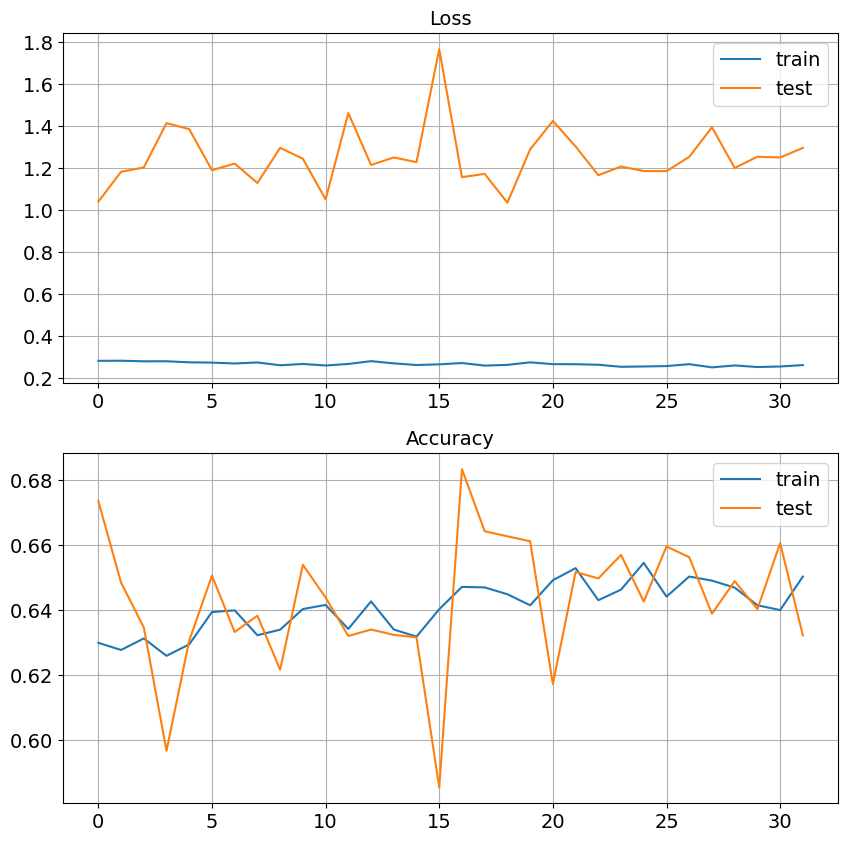

In [45]:
fig,ax = plt.subplots(2,1, figsize=(10,10))
ax[0].set_title('Loss')
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].legend()
ax[0].grid()

ax[1].set_title('Accuracy')
ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='test')
ax[1].legend()
ax[1].grid()